In [2]:
from sklearn.cluster import DBSCAN
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from geopy.distance import distance
import numpy as np
from matplotlib import pyplot as plt

In [1]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [40]:
uji_data = pd.read_csv('Data\\AllData.csv')
dbscan_fit = uji_data[['TIMESTAMP', 'USERID', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION']]

# floorplan for visualisation
floorplan = plt.imread("Data\\UJI_B012_floorplan.png")

## Clustering data points of each user

#### Define hyperparameter and similarity metric for DBScan

In [5]:
dist_threshold = 5
min_pts = 20
TRANSFORMER = Transformer.from_crs("epsg:3857", "epsg:4326")

def similarity(x, y):
    if x[4] != y[4] or x[5] != y[5] or x[6] != y[6]:
        # assume they are unreachable if they are in diff building, floor or room
        return dist_threshold + 10
    
    x1, y1 = TRANSFORMER.transform(x[3], x[2])
    x2, y2 = TRANSFORMER.transform(y[3], y[2])
    
    temp = distance((x1, y1), (x2, y2)).meters
    return temp

#### DBScan

In [6]:
dbscan = DBSCAN(dist_threshold, min_pts, metric=similarity)
cluster_user = dbscan_fit.groupby(['USERID']).apply(lambda x: dbscan.fit_predict(x))

D:\USER\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [43]:
pd.options.mode.chained_assignment = None
dbscan_fit["cluster"] = -1

i = 0
for group, data in dbscan_fit.groupby(['USERID']):
    dbscan_fit.iloc[dbscan_fit['USERID'] == group, 8] = cluster_user[i]
    i+= 1

#### Visualisation

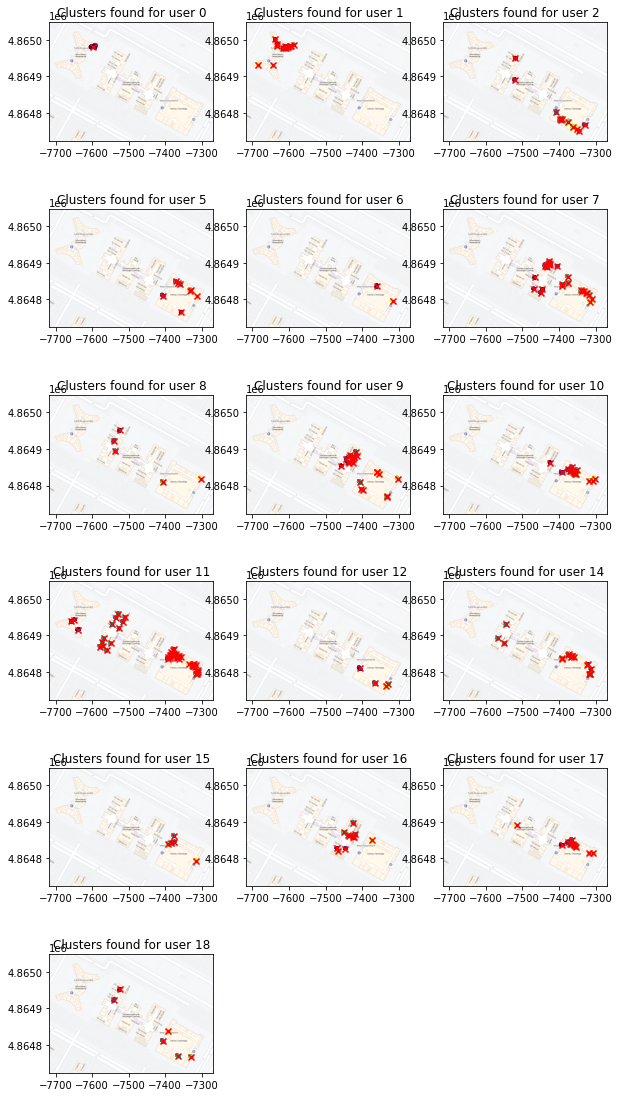

In [45]:
x_left, y_bottom = -7717, 4864723
width, height = floorplan.shape[1], floorplan.shape[0]
scale = 0.40

plt.figure(figsize=(10,20))
i = 1
for group, data in dbscan_fit.groupby(['USERID']):
    
    removed_noise = data[data['cluster'] != -1]
    removed_noise = removed_noise[removed_noise['cluster'].duplicated(keep=False)] # remove cluster with only one datapt
    
    if removed_noise.shape[0] == 0:
        continue
        
    ax = plt.subplot(6, 3, i)
    
    centroids_user = removed_noise.groupby('cluster')[['LONGITUDE', 'LATITUDE']].apply(lambda x: x.mean())
    centroids_user['cluster'] = centroids_user.index
    
    ax.imshow(floorplan, extent=[x_left, x_left + scale*width, y_bottom, y_bottom + scale*height])
    ax.scatter(removed_noise['LONGITUDE'], removed_noise['LATITUDE'], c=removed_noise['cluster'], alpha = 0.4, s = 10)
    ax.scatter(centroids_user['LONGITUDE'], centroids_user['LATITUDE'], c="red", marker='x')
    ax.set_aspect('equal', 'box')
    ax.set_title('Clusters found for user ' + str(group))
    
    i += 1

#### Output to file for future retrieval

In [30]:
dbscan_fit.to_csv('Outputs\\4\\dbscan_each_user.csv', index=False)

## Clustering data points of all users

#### Prepare data using centroids from the first clustering results

In [18]:
removed_noise = dbscan_fit[dbscan_fit['cluster'] != -1]
removed_noise = removed_noise[removed_noise['cluster'].duplicated(keep=False)] # remove cluster with only one datapt

mode = lambda x: x.value_counts().index[0]
centroids_user = removed_noise.groupby(['USERID', 'cluster']).agg({'LONGITUDE': 'mean',
                                                                   'LATITUDE': 'mean',
                                                                   'FLOOR': mode,
                                                                   'BUILDINGID': mode, 
                                                                   'SPACEID': mode,
                                                                   'RELATIVEPOSITION': 'count'})
centroids_user = centroids_user.reset_index()
centroids_user.rename(columns={'RELATIVEPOSITION':'pts_count'}, inplace=True)

#### Define hyperparameters

In [19]:
dist_threshold = 5
min_pts = 2
# Same similarity metric as the first clustering 

In [20]:
dbscan = DBSCAN(dist_threshold, min_pts, metric=similarity)
cluster_whole = dbscan.fit_predict(centroids_user)

D:\USER\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [26]:
centroids_user["cluster2"] = cluster_whole

In [35]:
removed_noise = centroids_user[centroids_user['cluster2'] != -1]
removed_noise = removed_noise[removed_noise['cluster2'].duplicated(keep=False)] # remove cluster with only one datapt

mode = lambda x: x.value_counts().index[0]
centroids_whole = removed_noise.groupby(['cluster2']).agg({'USERID': 'count',
                                                           'LONGITUDE': 'mean',
                                                           'LATITUDE': 'mean',
                                                           'FLOOR': mode,
                                                           'BUILDINGID': mode, 
                                                           'SPACEID': mode})
centroids_whole = centroids_whole.reset_index()
centroids_whole.rename(columns={'USERID':'pts_count'}, inplace=True)

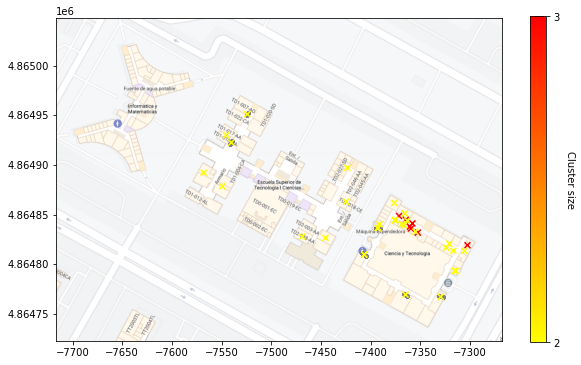

In [48]:
plt.figure(figsize=(10,6))
plt.axes().set_aspect('equal', 'box')
plt.imshow(floorplan, extent=[x_left, x_left + scale*width, y_bottom, y_bottom + scale*height])
plt.scatter(removed_noise['LONGITUDE'], removed_noise['LATITUDE'], c="grey", s = 10)
plt.scatter(centroids_whole['LONGITUDE'], centroids_whole['LATITUDE'], c=centroids_whole['pts_count'], cmap='autumn_r', marker='x')

cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([i for i in range(2, centroids_whole['pts_count'].max()+1)])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Cluster size', rotation=270)

plt.show()

In [39]:
centroids_user.to_csv('Outputs\\4\\dbscan_all_users.csv', index=False)
centroids_whole.to_csv('Outputs\\4\\dbscan_centroids.csv', index=False)